# Creating and Planting Signals Within Noise
Elizabeth Kapelevich

In [2]:
import numpy as np
import math
from scipy import interpolate
import matplotlib.pyplot as plt

### Interpolation

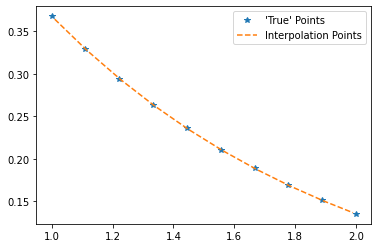

In [2]:
x = np.linspace(1, 2, 10)
y = np.exp(-x)
s = interpolate.interp1d(x, y)
X = np.linspace(1.01, 1.99, 10000)
Y = s(X)
plt.plot(x, y, "*", label = "'True' Points")
plt.plot(X, Y, '--', label = "Interpolation Points")
plt.legend()

### Finding Signals Within Noise
#### (1) Write a function that will accept the time boundaries of the data and the signal and embed the signal in the data
#### (2)  Write a function that will accept a data stream, and template, and a time step (Delta t) and compute the cross-correlation output
#### (3) Plot the cross-correlation output as a function of time, and see if you are able to recover the signal. Inject the signal at various times in side the data and see if your recovery is consistent

## (1)

## $ \Delta t * n = duration $

In [3]:
def get_noise(t_0, t_end, del_T):
    
    """
    This function will take as input the boundaries of a time stamp
    from some noise and the interval between each value.
    
    INPUT:
    ------
      t_0 : start time of noise
    t_end : end time of noise
      del_T : interval of time between each value
    
    RETURNS:
    --------
    The time series for random noise.
    
    """

    duration_data = t_end - t_0
    number_of_values = duration_data / del_T                        # calculating number of time stamps
    del_T_prime = duration_data / math.ceil(number_of_values)       # new interval of the noise data to allow  
                                                                    # array to reach end point
    
    time_series = np.arange(t_0, t_end + del_T_prime, del_T_prime)  # array from beginning to end of noise time stamp
                                                                    # with increments of the standard deviation
    noise = np.random.random(len(time_series))                      # random values with same length as time_series
    return (time_series, noise, del_T_prime)

## $A^{\frac{{-(t - t_{\rm mean})^2}}{2\sigma}}\sin(2\pi ft)$

In [4]:
def get_signal(A, t_0, t_end, del_T, f, sigma):
    
    """
    This function will take as input the amplitude, boundaries of a time stamp
    from a signal, the frequency, and the standard deviation.
    
    INPUT:
    ------
        f : frequency
        A : amplitude
      t_0 : start time of a signal
    t_end : end time of a signal
    del_T : interval of time between each value
    sigma : standard deviation
    
    RETURNS:
    --------
    The time series for a signal.
    
    """

    duration_data = t_end - t_0
    number_of_values = duration_data / del_T                        # calculating number of time stamps
    del_T_prime = duration_data / math.ceil(number_of_values)       # new interval of the noise data to allow  
                                                                    # array to reach end point
    t = np.arange(t_0, t_end + del_T_prime, del_T_prime)
    
    t_mean = (t_0 + t_end) / 2                                      # finding center of signal
    S = A*np.sin(2*np.pi*f*t)*np.exp((-(t - t_mean)**2)/(2*sigma))  # calculating sine gaussian

    return (t, S, del_T_prime)

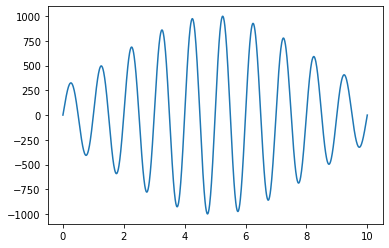

In [11]:
t_0 = 0
t_end = 10
del_T_prime = 0.01
t = np.arange(t_0, t_end + del_T_prime, del_T_prime)
t_mean = (t_0 + t_end) / 2 
S = 1000*np.sin(2*np.pi*1*t)*np.exp((-(t - t_mean)**2)/(2*10))
plt.plot(t, S)

In [28]:
def final_data(a, t_signal_start, t_signal_end, t_noise_start, t_noise_end,
               del_T, f, sigma):
    """
    This function will take as input the amplitude, time boundaries
    of the signal and noise, interval between their values, the
    frequency, and standard deviation.
    
    INPUT:
    ------
             A : amplitude
             f : frequency
         sigma : standard deviation
         del_T : interval of time between each value
   t_noise_end : end time of noise
  t_signal_end : end time of signal
 t_noise_start : start time of noise
t_signal_start : start time of signal
    
    RETURNS:
    --------
    The calculation for cross-correlating a signal embedded 
    within random noise with zero-padding if necessary.
    
    """
    time_series_signal, signal_values, del_T_signal = get_signal(a, t_signal_start, t_signal_end,
                                     del_T, f, sigma)
    time_series_noise, noise_values, del_T_noise = get_noise(t_noise_start, t_noise_end, del_T)
    
    s = interpolate.interp1d(time_series_signal, signal_values)
    
    index1 = time_series_noise > time_series_signal[0]   # boolean = False before signal in noise time-series
    index2 = time_series_noise < time_series_signal[-1]  # boolean = False after signal in noise time_series
    time_series_intersect = index1*index2                # multiplying arrays into one array of booleans
    
    zeroes = np.zeros_like(noise_values)                          # create an array of zeroes same length 
                                                                  # as noise_values
    signal_time_stamps = time_series_noise[time_series_intersect] # keeping only boolean = True
    signal = s(signal_time_stamps)

    data_in_signal = noise_values[time_series_intersect] + signal       # embedding signal in noise
    data_before_signal = noise_values[index2*(~time_series_intersect)]  # prepping to graph noise before signal
    data_after_signal = noise_values[index1*(~time_series_intersect)]   # prepping to graph noise after signal

    alldata = np.hstack((data_before_signal, data_in_signal, data_after_signal)) # 'appending' the three arrays
    
    return (time_series_noise, alldata)

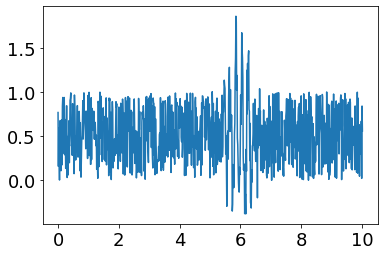

In [29]:
a = 1
signal_start_time = 5
signal_end_time = 7
t_duration = signal_end_time - signal_start_time
noise_start_time = 0
noise_end_time = 10
del_T = 0.012
f = 5
sigma = 0.1
times, alldata = final_data(a, signal_start_time, signal_end_time, noise_start_time,
                           noise_end_time, del_T, f, sigma)
plt.plot(times, alldata)

(-0.4918815862775554, 1.9686851875380709)

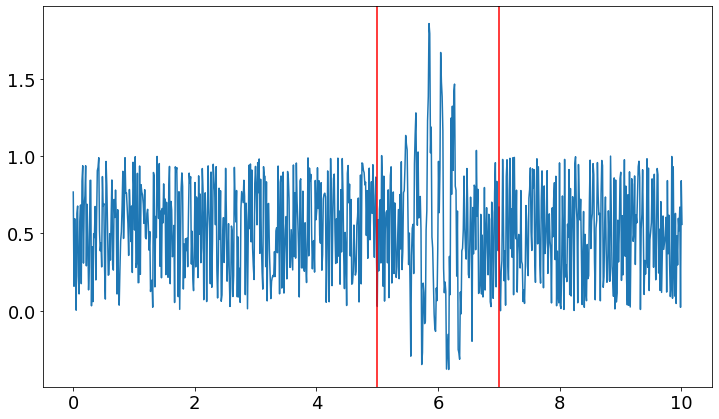

In [32]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(12,7))
plt.plot(times, alldata)
ax = plt.gca()
ylim = ax.get_ylim()
plt.plot([5, 5], ylim, 'r-')
plt.plot([7, 7], ylim, 'r-')
plt.ylim(ylim)

## (2)

#### First create the time-series (np.array), where it starts at t_0 and goes on for t_duration in steps of del_T

#### Use sine guassian function to calculate the mean of time using duration, length, and initial value

#### It should output values and time steps of the signal

#### Save yourself by generating np.array using zero-padding

In [ ]:
def template(f, sigma, t_0, t_duration, del_T):

# np.diff(alldata)[0]

    """
    This function will take as input the frequency, standard
    deviation, initial time, duration time, and interval
    of time between each value.
    
    INPUT:
    ------
         f : frequency
       t_0 : start time of a signal
     del_T : interval of time between each value
     sigma : standard deviation
t_duration : duration of time for the signal
    
    RETURNS:
    --------
    The template that will match the given signal.
    
    """
# at any t_0 value, generate the template
# take the data, plot it, generate template
# once its generated, construct zero-padding
# then sum the product of them

# interpolate the signal time stamps with the template
# make a function that will zero-pad so everything outside of signal will be zero
    t_end = t_duration + t_0